In [1]:
# Kutuphanelerin Yuklenmesi ve Konfigurasyon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
import warnings
import math

# Scikit-learn Modulleri
from sklearn.model_selection import train_test_split, RandomizedSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# Metrikler
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                             f1_score, precision_recall_curve, average_precision_score, 
                             roc_auc_score)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from scipy.stats import randint, uniform
from sklearn.metrics import recall_score, accuracy_score

# Ayarlar
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Kutuphaneler yuklendi ve analiz ayarlari yapildi.")

Kutuphaneler yuklendi ve analiz ayarlari yapildi.


Veri seti basariyla yuklendi. Ham Boyutlar: (1911073, 43)
Sutun filtresi uygulandi. Yeni Boyutlar: (1911073, 36)


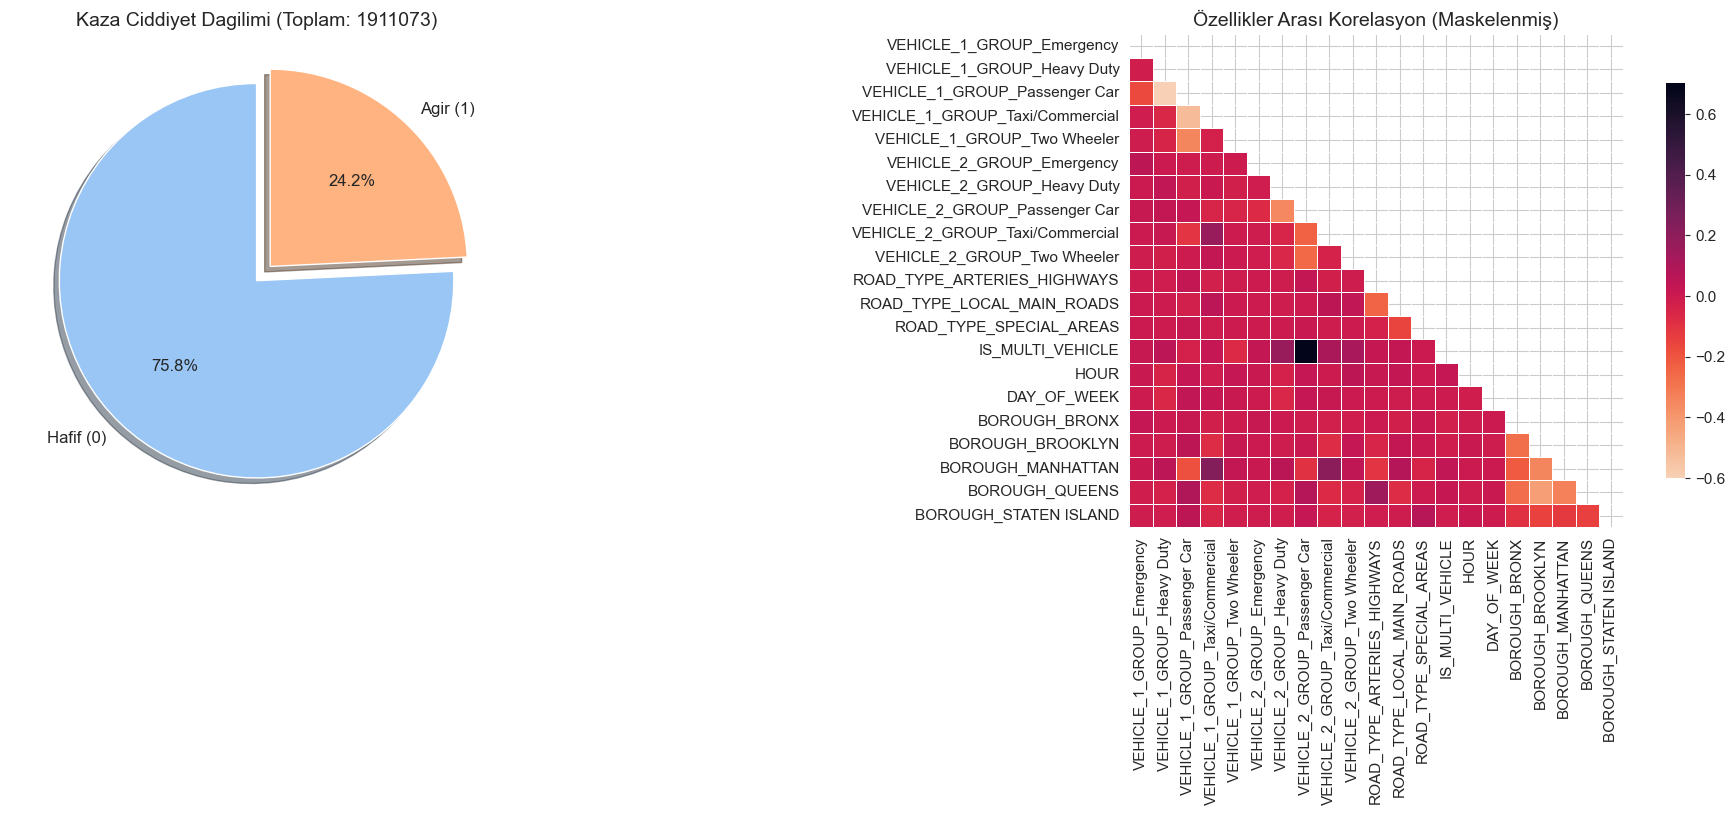

Veri görselleştirildi ve model eğitimine hazır hale getirildi.


In [2]:
# --- 1. VERİ YÜKLEME VE İŞLEME ---
file_name = "NYC_Crash_Model_Final_Last.csv" 

try:
    df = pd.read_csv(file_name)
    print(f"Veri seti basariyla yuklendi. Ham Boyutlar: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError("Belirtilen dosya bulunamadi.")

target_col = 'SEVERITY'

# 2 Olanlari 1 Yapma 
df[target_col] = df[target_col].replace(2, 1)

# Sütun Seçimi
selected_features = [
    'VEHICLE_1_GROUP_Emergency', 'VEHICLE_1_GROUP_Heavy Duty', 
    'VEHICLE_1_GROUP_Passenger Car', 'VEHICLE_1_GROUP_Taxi/Commercial', 
    'VEHICLE_1_GROUP_Two Wheeler',
    'VEHICLE_2_GROUP_Emergency', 'VEHICLE_2_GROUP_Heavy Duty', 
    'VEHICLE_2_GROUP_Passenger Car', 'VEHICLE_2_GROUP_Taxi/Commercial', 
    'VEHICLE_2_GROUP_Two Wheeler',
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 'ROAD_TYPE_LOCAL_MAIN_ROADS', 'ROAD_TYPE_SPECIAL_AREAS',
    'IS_MULTI_VEHICLE',
    'HOUR', 'DAY_OF_WEEK',
    'BOROUGH_BRONX', 'BOROUGH_BROOKLYN', 'BOROUGH_MANHATTAN', 
    'BOROUGH_QUEENS', 'BOROUGH_STATEN ISLAND',
    # Faktör gruplarını model eğitimi için tutuyoruz ama alttaki görselleştirmede hariç tutacağız.
    'FACTOR_1_GROUP_Aggressive Driving', 'FACTOR_1_GROUP_Distracted',
    'FACTOR_1_GROUP_Environmental', 'FACTOR_1_GROUP_Fatigued',
    'FACTOR_1_GROUP_Impaired', 'FACTOR_1_GROUP_Mechanical Failure',
    'FACTOR_1_GROUP_Unspecified',
    'FACTOR_2_GROUP_Aggressive Driving', 'FACTOR_2_GROUP_Distracted',
    'FACTOR_2_GROUP_Environmental', 'FACTOR_2_GROUP_Fatigued',
    'FACTOR_2_GROUP_Impaired', 'FACTOR_2_GROUP_Mechanical Failure',
    'FACTOR_2_GROUP_No Contribution'
]

# DataFrame'i filtrele
try:
    df = df[selected_features + [target_col]]
    print(f"Sutun filtresi uygulandi. Yeni Boyutlar: {df.shape}")
except KeyError as e:
    print(f"HATA: Secilen sutunlardan bazilari CSV dosyasinda bulunamadi: {e}")
    raise

# --- 2. GÖRSELLEŞTİRME ---

# Çizim alanı oluştur
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.set_style("white") 

# --- A) Pasta Grafiği (Sol Taraf) ---
counts = df[target_col].value_counts()
labels = [f'Hafif (0)', f'Agir (1)']
# Resimdeki renklere yakın pastel mavi ve turuncu
colors = ['#9ac6f5', '#ffb380'] 
explode = (0, 0.1)  # İkinci dilimi dışarı çıkar

axes[0].pie(counts, labels=labels, autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=explode, 
            shadow=True, textprops={'fontsize': 12})
axes[0].set_title(f'Kaza Ciddiyet Dagilimi (Toplam: {len(df)})', fontsize=14)

# --- B) Maskelenmiş Korelasyon Matrisi ---
# Sadece resimdeki özellikleri korelasyon için seçelim 
corr_cols = [col for col in selected_features if 'FACTOR' not in col]
corr_matrix = df[corr_cols].corr()

# Üst üçgeni gizlemek için maske oluştur
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Isı haritasını çiz
sns.heatmap(corr_matrix, mask=mask, cmap='rocket_r', 
            vmax=0.7, vmin=-0.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8},
            ax=axes[1])

axes[1].set_title('Özellikler Arası Korelasyon (Maskelenmiş)', fontsize=14)

plt.tight_layout()
plt.show()

# --- 3. EĞİTİM VE TEST VERİSİNİN HAZIRLANMASI ---
X = df.drop(columns=[target_col])
y = df[target_col]

# Stratified Split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    print("UYARI: Stratify yapilamadi. Normal split yapiliyor.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print("Veri görselleştirildi ve model eğitimine hazır hale getirildi.")

In [3]:
# Hiperparametre Optimizasyonu ve Model Egitimi

warnings.filterwarnings('ignore')

print("Hiperparametre optimizasyonu baslatiliyor (Bu islem veri boyutuna gore vakit alabilir)...")

# 1. Random Forest Optimizasyonu
rf_params = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'class_weight': ['balanced', 'balanced_subsample']
}

print("Random Forest icin parametre araniyor...")
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=10, 
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_train_scaled, y_train)
best_rf = rf_search.best_estimator_
print(f"Random Forest En Iyi Parametreler: {rf_search.best_params_}")

# 2. XGBoost Optimizasyonu
spw = float(sum(y_train == 0)) / sum(y_train == 1)

xgb_params = {
    'n_estimators': randint(100, 400),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': [spw]
}

print("XGBoost icin parametre araniyor...")
xgb_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1, verbosity=0), # verbosity=0 uyarilari kapatir
    param_distributions=xgb_params,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
xgb_search.fit(X_train_scaled, y_train)
best_xgb = xgb_search.best_estimator_
print(f"XGBoost En Iyi Parametreler: {xgb_search.best_params_}")

# 3. Voting ve Stacking Modellerinin Kurulmasi
print("Ensemble modeller (Voting & Stacking) olusturuluyor...")

voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    voting='soft', n_jobs=-1
)

stacking_clf = StackingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# Tum Modellerin Sozlugu
models = {
    "Random Forest (Tuned)": best_rf,
    "XGBoost (Tuned)": best_xgb,
    "Voting (Tuned)": voting_clf,
    "Stacking (Tuned)": stacking_clf
}

results = {}

# Modellerin Egitilmesi ve Test Edilmesi
for name, model in models.items():
    if name not in ["Random Forest (Tuned)", "XGBoost (Tuned)"]:
        model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrik Hesaplamalari
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Sonuclari saklama
    results[name] = {
        "model": model, "prob": y_prob, "pred": y_pred, 
        "Accuracy": acc, "Recall": rec, "F1": f1, "AUC": roc_auc
    }
    
    print("-" * 30)
    print(f"MODEL: {name}")
    print(f"Accuracy: {acc:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

print("\n" + "="*40)
print("Tum modellerin egitim ve test surecleri basariyla tamamlandi.")
print("="*40)

Hiperparametre optimizasyonu baslatiliyor (Bu islem veri boyutuna gore vakit alabilir)...
Random Forest icin parametre araniyor...


Exception ignored in: <function ResourceTracker.__del__ at 0x10c265c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105811c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110a11c60>
Traceback (most recent call last

Random Forest En Iyi Parametreler: {'class_weight': 'balanced', 'max_depth': 13, 'min_samples_split': 9, 'n_estimators': 251}
XGBoost icin parametre araniyor...


Exception ignored in: <function ResourceTracker.__del__ at 0x105ee9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1076c5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


XGBoost En Iyi Parametreler: {'colsample_bytree': np.float64(0.6923575302488596), 'learning_rate': np.float64(0.05820509320520235), 'max_depth': 6, 'n_estimators': 363, 'scale_pos_weight': 3.1253811407508945, 'subsample': np.float64(0.6137554084460873)}
Ensemble modeller (Voting & Stacking) olusturuluyor...
------------------------------
MODEL: Random Forest (Tuned)
Accuracy: 0.7287 | Recall: 0.4738 | F1: 0.7316 | AUC: 0.7048
------------------------------
MODEL: XGBoost (Tuned)
Accuracy: 0.7119 | Recall: 0.5160 | F1: 0.7210 | AUC: 0.7081


Exception ignored in: <function ResourceTracker.__del__ at 0x107065c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


------------------------------
MODEL: Voting (Tuned)
Accuracy: 0.7183 | Recall: 0.5009 | F1: 0.7252 | AUC: 0.7074


Exception ignored in: <function ResourceTracker.__del__ at 0x121811c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105881c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106265c60>
Traceback (most recent call last

------------------------------
MODEL: Stacking (Tuned)
Accuracy: 0.7917 | Recall: 0.2702 | F1: 0.7561 | AUC: 0.7075

Tum modellerin egitim ve test surecleri basariyla tamamlandi.


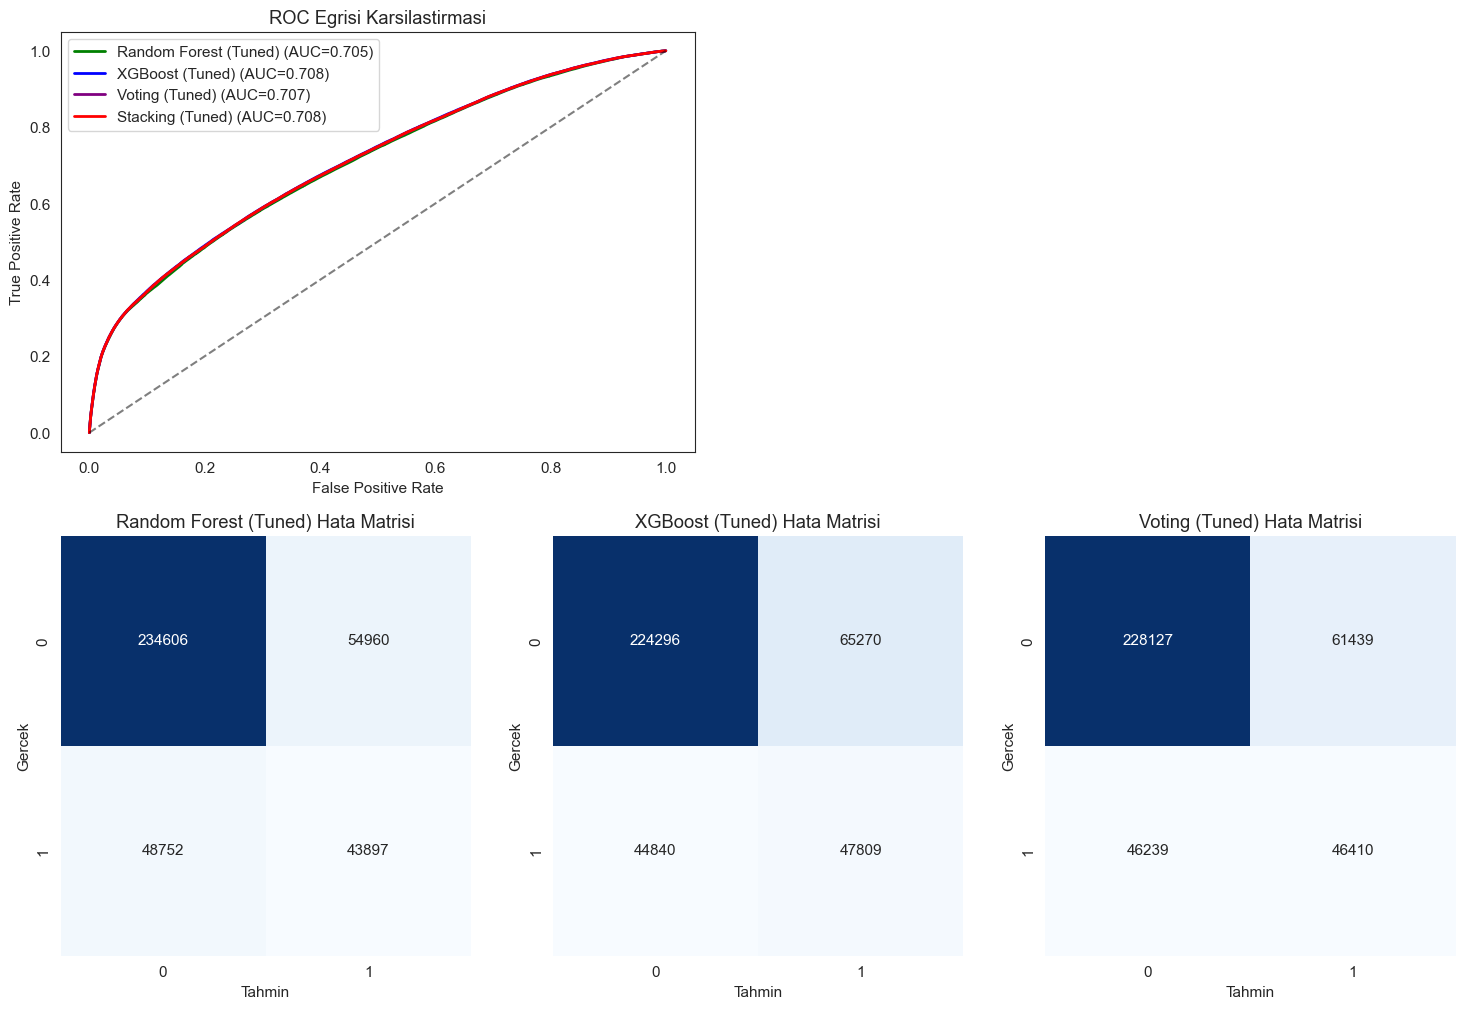

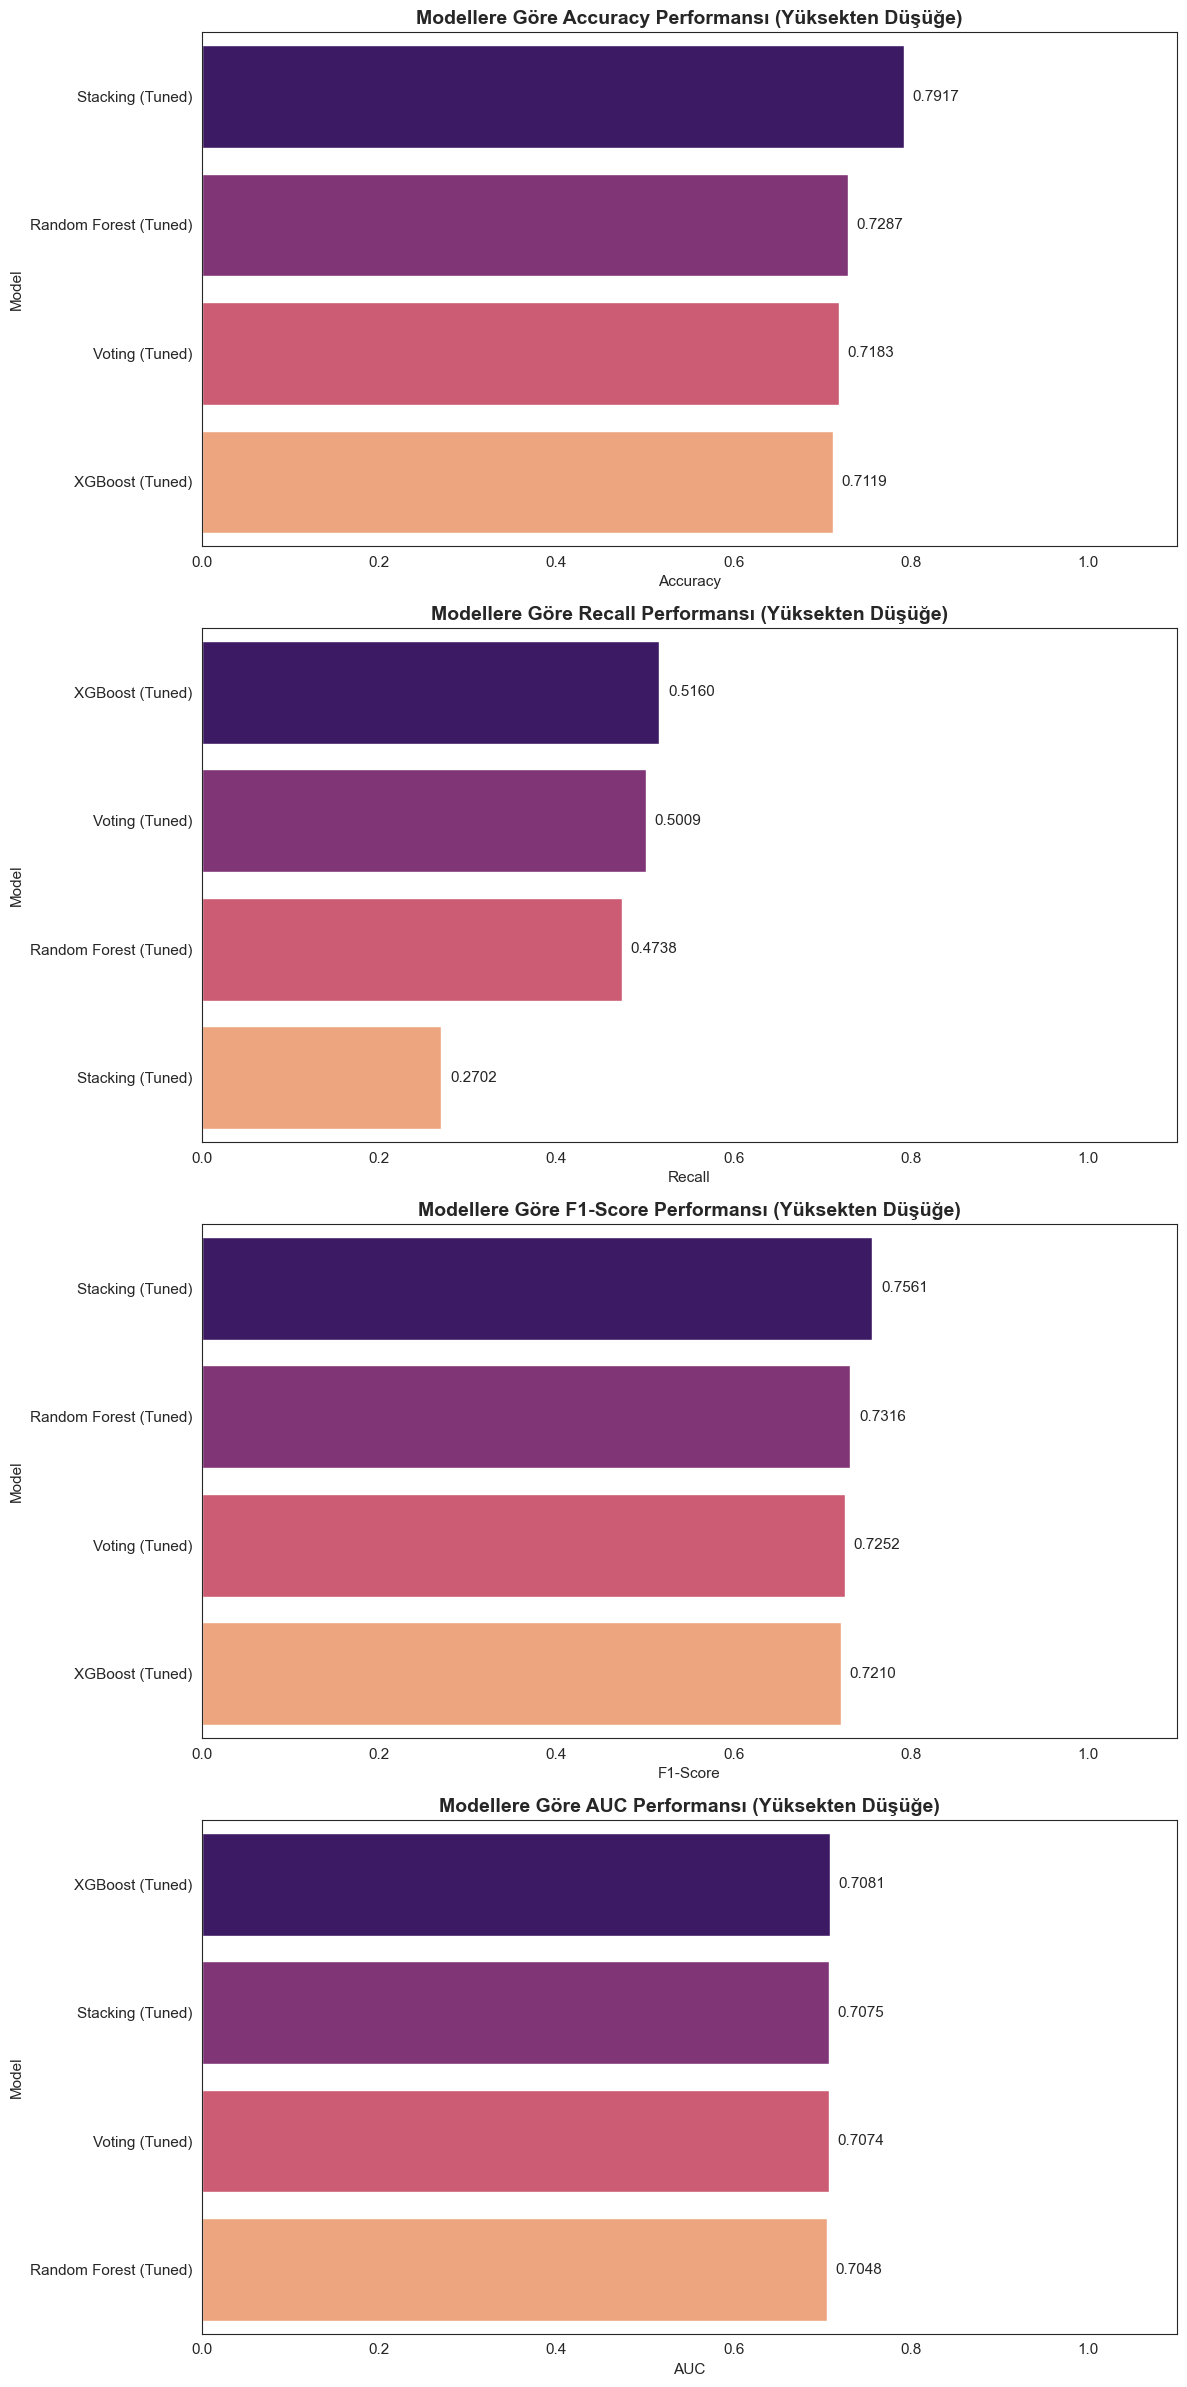


!!!!!!!!!!!!!!!!!!!! MODEL PERFORMANS SIRALAMALARI !!!!!!!!!!!!!!!!!!!!

>>> AUC Değerine Göre En İyi Modeller:


,Model,Accuracy,Recall,F1-Score,AUC
0,XGBoost (Tuned),0.711916,0.516023,0.720953,0.708121
1,Stacking (Tuned),0.791685,0.270170,0.756143,0.707529
2,Voting (Tuned),0.718279,0.500923,0.725161,0.707376
3,Random Forest (Tuned),0.728655,0.473799,0.731583,0.704837



>>> Recall Değerine Göre En İyi Modeller:


,Model,Accuracy,Recall,F1-Score,AUC
0,XGBoost (Tuned),0.711916,0.516023,0.720953,0.708121
1,Voting (Tuned),0.718279,0.500923,0.725161,0.707376
2,Random Forest (Tuned),0.728655,0.473799,0.731583,0.704837
3,Stacking (Tuned),0.791685,0.270170,0.756143,0.707529



>>> F1-Score Değerine Göre En İyi Modeller:


,Model,Accuracy,Recall,F1-Score,AUC
0,Stacking (Tuned),0.791685,0.270170,0.756143,0.707529
1,Random Forest (Tuned),0.728655,0.473799,0.731583,0.704837
2,Voting (Tuned),0.718279,0.500923,0.725161,0.707376
3,XGBoost (Tuned),0.711916,0.516023,0.720953,0.708121


In [4]:
# Performans Karsilastirmasi 
# 1. BOLUM: Orijinal Grafiklerin Cizimi
plt.figure(figsize=(18, 12))

# A) ROC Egrileri
plt.subplot(2, 2, 1)
colors = ['green', 'blue', 'purple', 'red']
for (name, res), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, res['prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['AUC']:.3f})", color=color, lw=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('ROC Egrisi Karsilastirmasi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# B) Confusion Matrix'ler 
for i, (name, res) in enumerate(list(results.items())[:3]): 
    plt.subplot(2, 3, i+4)
    cm = confusion_matrix(y_test, res['pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Hata Matrisi')
    plt.xlabel('Tahmin')
    plt.ylabel('Gercek')

plt.tight_layout()
plt.show()

# 2. BOLUM: Yeni Metrik Grafigi (Alt Alta)
metrics_data = []
for name, res in results.items():
    metrics_data.append({
        "Model": name,
        "Accuracy": res["Accuracy"],
        "Recall": res["Recall"],
        "F1-Score": res["F1"],
        "AUC": res["AUC"]
    })
df_metrics = pd.DataFrame(metrics_data)

# Her metrik icin ayri bir alt grafik
metrics_list = ["Accuracy", "Recall", "F1-Score", "AUC"]
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

for i, metric in enumerate(metrics_list):
    df_sorted = df_metrics.sort_values(by=metric, ascending=False)
    sns.barplot(x=metric, y="Model", data=df_sorted, ax=axes[i], palette="magma")
    axes[i].set_title(f'Modellere Göre {metric} Performansı (Yüksekten Düşüğe)', fontsize=14, fontweight='bold')
    axes[i].set_xlim(0, 1.1)
    
    # Degerleri cubuklarin uzerine yaz
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_width():.4f}', (p.get_width() + 0.01, p.get_y() + p.get_height()/2), va='center')

plt.tight_layout()
plt.show()

# 3. BOLUM: Sirali Karsilastirma Tablolari
print("\n" + "!"*20 + " MODEL PERFORMANS SIRALAMALARI " + "!"*20)
for sort_param in ["AUC", "Recall", "F1-Score"]:
    print(f"\n>>> {sort_param} Değerine Göre En İyi Modeller:")
    display(df_metrics.sort_values(by=sort_param, ascending=False).reset_index(drop=True))

En iyi model (Detaylı analiz için): XGBoost (Tuned)
t-SNE haritası oluşturuluyor ...


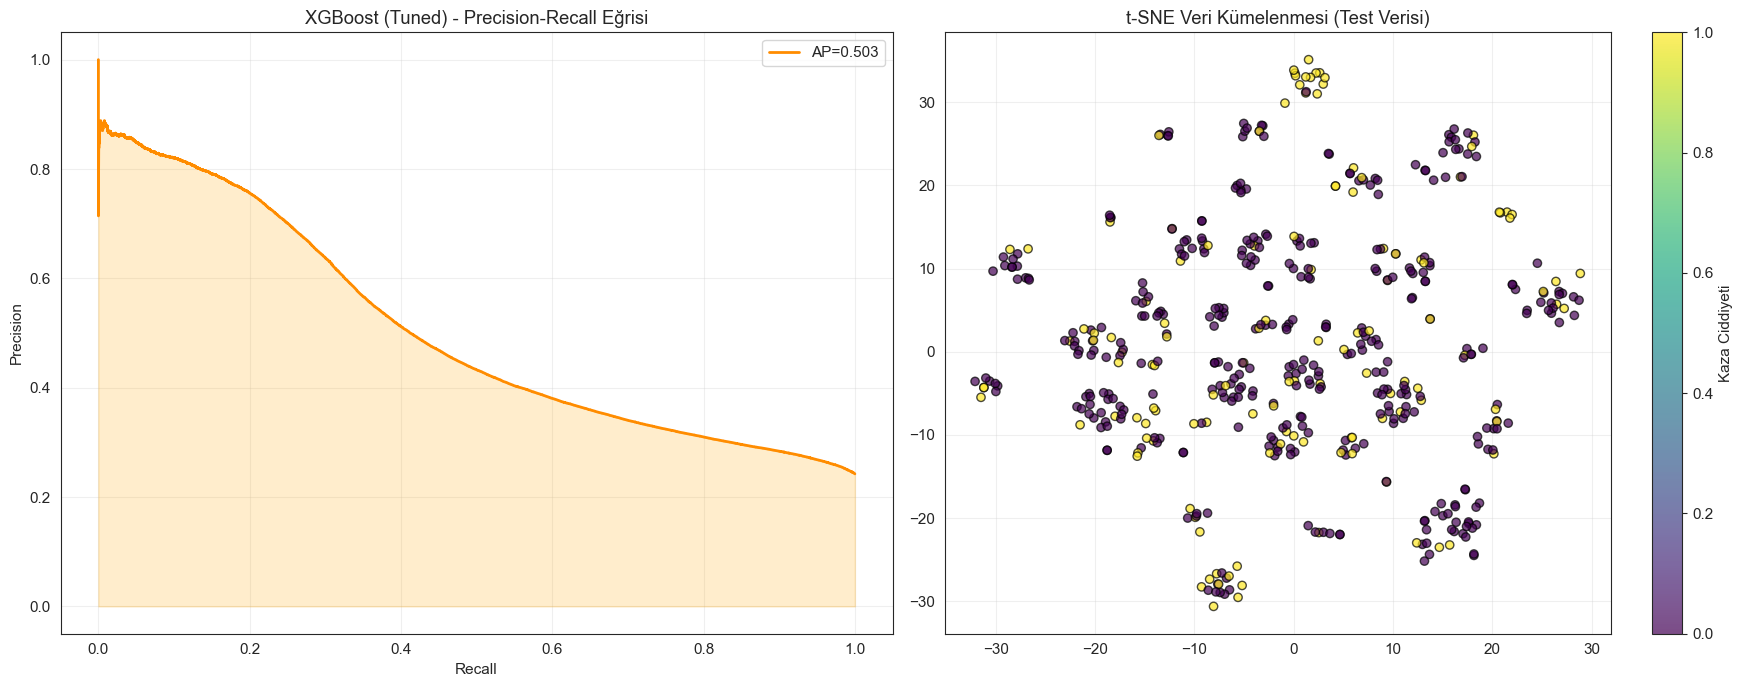


--- Tüm Modeller İçin Learning Curve Hesaplanıyor ---
(Not: Bu işlem model sayısı x işlem gücüne göre biraz zaman alabilir)

Hesaplanıyor: Random Forest (Tuned)...


Exception ignored in: <function ResourceTracker.__del__ at 0x108211c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x111465c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107a81c60>
Traceback (most recent call last

Hesaplanıyor: XGBoost (Tuned)...


Exception ignored in: <function ResourceTracker.__del__ at 0x1038a5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Hesaplanıyor: Voting (Tuned)...


Exception ignored in: <function ResourceTracker.__del__ at 0x106f79c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1078c9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103f79c60>
Traceback (most recent call last

Hesaplanıyor: Stacking (Tuned)...


Exception ignored in: <function ResourceTracker.__del__ at 0x107695c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110a65c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1073c5c60>
Traceback (most recent call last

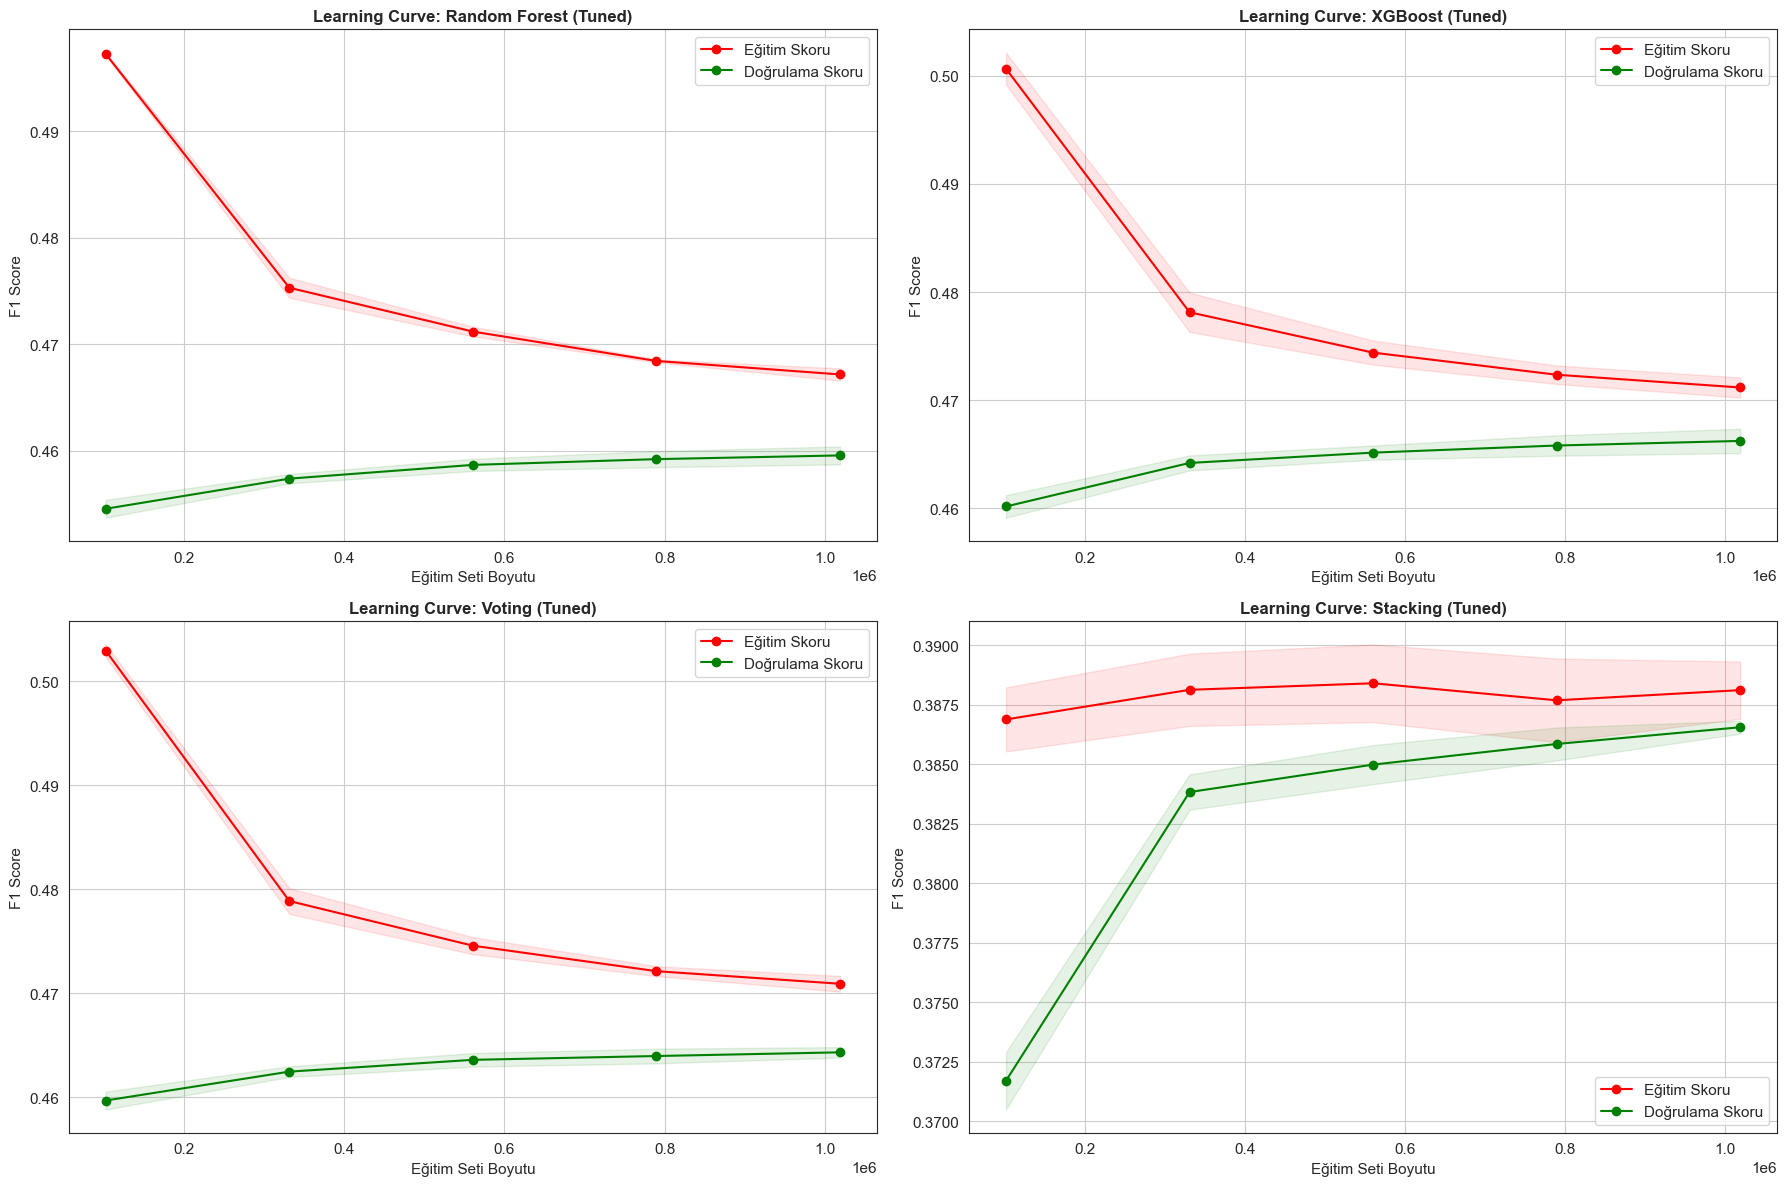

In [5]:
# 1. En iyi modelin ismini bul 
best_model_name = max(results, key=lambda k: results[k]['AUC'])
best_res = results[best_model_name]
print(f"En iyi model (Detaylı analiz için): {best_model_name}")

# --- BÖLÜM 1: EN İYİ MODELİN DETAY ANALİZİ  ---
fig = plt.figure(figsize=(18, 7)) # Üst kısım için alan

# A) Precision-Recall Eğrisi
ax1 = fig.add_subplot(1, 2, 1)
precision, recall, _ = precision_recall_curve(y_test, best_res['prob'])
avg_prec = average_precision_score(y_test, best_res['prob'])
ax1.plot(recall, precision, color='darkorange', lw=2, label=f'AP={avg_prec:.3f}')
ax1.fill_between(recall, precision, color='orange', alpha=0.2)
ax1.set_title(f'{best_model_name} - Precision-Recall Eğrisi')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()
ax1.grid(True, alpha=0.3)

# B) t-SNE Görselleştirmesi
print("t-SNE haritası oluşturuluyor ...")
ax2 = fig.add_subplot(1, 2, 2)
limit = 500
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_test_scaled.iloc[:limit])
scatter = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test[:limit], cmap='viridis', alpha=0.7, edgecolors='k')
plt.colorbar(scatter, ax=ax2, label='Kaza Ciddiyeti')
ax2.set_title('t-SNE Veri Kümelenmesi (Test Verisi)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- BÖLÜM 2: TÜM MODELLERİN LEARNING CURVE ANALİZİ ---
print("\n--- Tüm Modeller İçin Learning Curve Hesaplanıyor ---")
print("(Not: Bu işlem model sayısı x işlem gücüne göre biraz zaman alabilir)\n")

# Model sayısı kadar grafik alanı oluştur
num_models = len(models)
cols = 2 # Yan yana 2 grafik olsun
rows = math.ceil(num_models / cols)

fig_lc, axes_lc = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes_lc = axes_lc.flatten() # Döngüde kolay erişim için düzleştir

for idx, (name, model) in enumerate(models.items()):
    ax = axes_lc[idx]
    print(f"Hesaplanıyor: {name}...")
    
    # Learning Curve Hesapla
    # n_jobs=-1 ile tüm işlemcileri kullanır, cv=3 ile hızı artırırız
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train, 
        cv=3, scoring='f1', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    # Ortalamalar ve Sapmalar
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Çizim
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_mean, 'o-', color="r", label="Eğitim Skoru")
    ax.plot(train_sizes, test_mean, 'o-', color="g", label="Doğrulama Skoru")

    ax.set_title(f'Learning Curve: {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel("Eğitim Seti Boyutu")
    ax.set_ylabel("F1 Score")
    ax.legend(loc="best")
    ax.grid(True)

# Eğer tek sayıda model varsa boş kalan grafikleri gizle
for i in range(num_models, len(axes_lc)):
    fig_lc.delaxes(axes_lc[i])

plt.tight_layout()
plt.show()

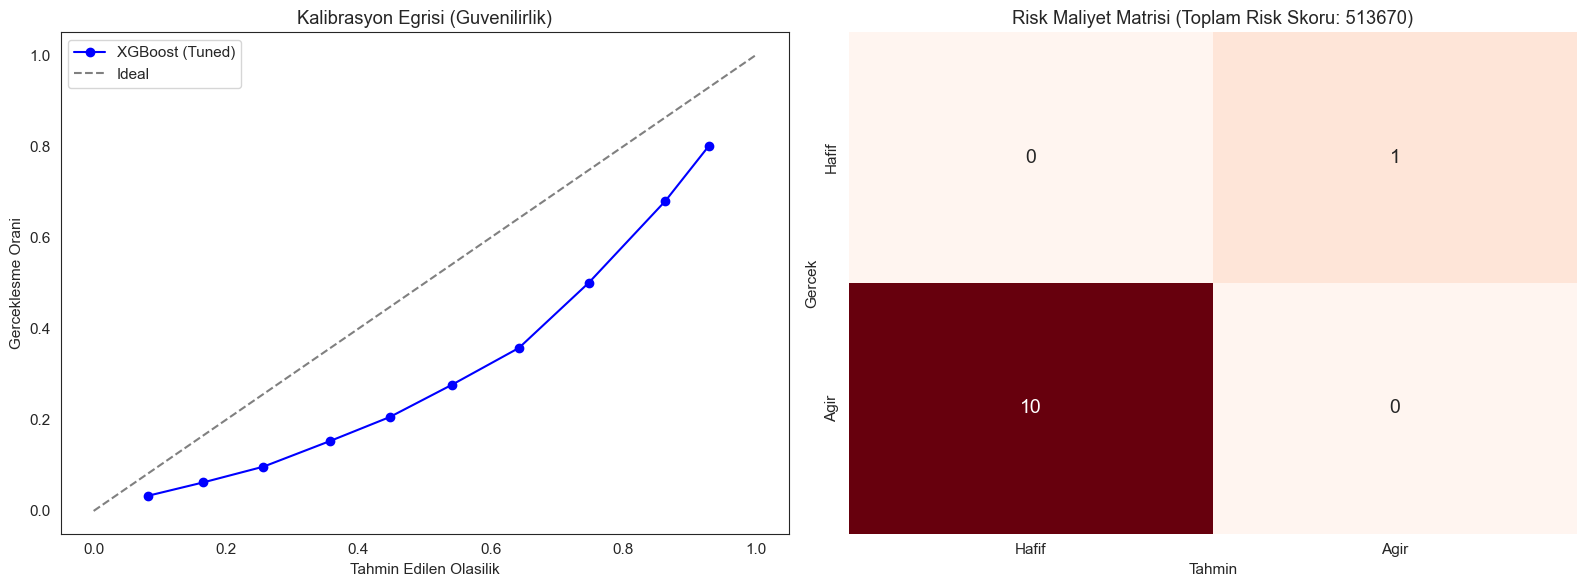

Risk Raporu (XGBoost (Tuned)):
Kacirilan Agir Kaza (FN): 44840
Hatali Alarm (FP): 65270
Toplam Risk Maliyeti: 513670


In [6]:
# hücre 6 Guvenilirlik ve Risk Analizi
plt.figure(figsize=(16, 6))

# A) Calibration Curve
plt.subplot(1, 2, 1)
prob_true, prob_pred = calibration_curve(y_test, best_res['prob'], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label=best_model_name, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
plt.title('Kalibrasyon Egrisi (Guvenilirlik)')
plt.xlabel('Tahmin Edilen Olasilik')
plt.ylabel('Gerceklesme Orani')
plt.legend()

# B) Risk Maliyet Analizi
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, best_res['pred'])
tn, fp, fn, tp = cm.ravel()

# Maliyet Senaryosu: FN (Agir kazayi kacirmak) maliyeti FP'den yuksek
cost_fp = 1
cost_fn = 10 
total_cost = (fp * cost_fp) + (fn * cost_fn)

# Maliyet Matrisi
cost_matrix = np.array([[0, cost_fp], [cost_fn, 0]])
sns.heatmap(cost_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 14})
plt.title(f'Risk Maliyet Matrisi (Toplam Risk Skoru: {total_cost})')
plt.xlabel('Tahmin')
plt.ylabel('Gercek')
plt.xticks([0.5, 1.5], ['Hafif', 'Agir'])
plt.yticks([0.5, 1.5], ['Hafif', 'Agir'])

plt.tight_layout()
plt.show()

print(f"Risk Raporu ({best_model_name}):")
print(f"Kacirilan Agir Kaza (FN): {fn}")
print(f"Hatali Alarm (FP): {fp}")
print(f"Toplam Risk Maliyeti: {total_cost}")

XGBoost (Tuned) modeli icin SHAP analizi yapiliyor...


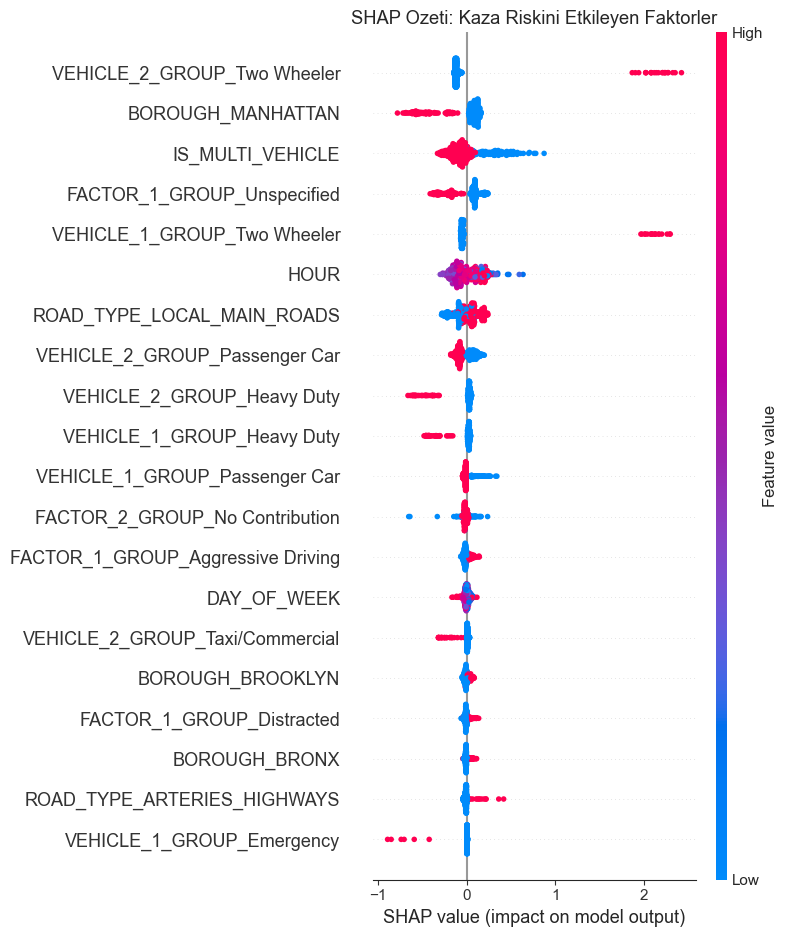

In [7]:
# hücre 7  SHAP Ozellik Onem Analizi
print(f"{best_model_name} modeli icin SHAP analizi yapiliyor...")

# Voting veya Stacking modelleri icin dogrudan TreeExplainer kullanilamaz.
# Bu durumda en iyi temel model uzerinden analiz gosterilir.
if best_model_name in ["Voting (Tuned)", "Stacking (Tuned)"]:
    print(f"Not: {best_model_name} karmasik model oldugu icin analiz bilesen model (XGBoost) uzerinden yapilacaktir.")
    model_for_shap = models["XGBoost (Tuned)"]
else:
    model_for_shap = best_res['model']

# SHAP Hesaplamasi
explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer.shap_values(X_test_scaled.iloc[:500])

plt.figure(figsize=(10, 8))
plt.title('SHAP Ozeti: Kaza Riskini Etkileyen Faktorler')
shap.summary_plot(shap_values, X_test_scaled.iloc[:500], show=True)